# FPL Optimisation

In [1]:
import requests
import pandas as pd
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set_style("darkgrid")

## Extracting data

### Extracting all Players and Teams data

In [2]:
#game data
url = 'https://fantasy.premierleague.com/api/bootstrap-static/'

r = requests.get(url)

json_data = r.json()

player_df = pd.DataFrame(json_data['elements'])
player_types_df = pd.DataFrame(json_data['element_types'])
teams_df = pd.DataFrame(json_data['teams'])

json_data.keys()

dict_keys(['events', 'game_settings', 'phases', 'teams', 'total_players', 'elements', 'element_stats', 'element_types'])

events = summary stats for each gameweek  
game_settings = overall settings for the game  
phases = start and stop gameweeks for months  
teams = summary data about the teams - seemingly no points/league table filled in though  
total_players = number of total players globally  
elements = all players and some summary stats  
element_stats = mapping for player stats labels eg. {'label': 'Goals scored', 'name': 'goals_scored'}  
element_types = positions and the rules per position  


### Extracting Fixtures

In [3]:
#game data
url = 'https://fantasy.premierleague.com/api/fixtures/'

r = requests.get(url)

json_data = r.json()

fixtures_df = pd.DataFrame(json_data)

### Extracting My Team

In [4]:
team_id = '1409005'
url2 = 'https://fantasy.premierleague.com/api/my-team/{}'.format(team_id)


In [5]:
password = input('Password=')
session = requests.session()

url = 'https://users.premierleague.com/accounts/login/'
payload = {
 'password': password,
 'login': 'lukebetham@hotmail.com',
 'redirect_uri': 'https://fantasy.premierleague.com/a/login',
 'app': 'plfpl-web'
}

session.post(url, data=payload)

response = session.get(url2)

json = response.json()
clear_output()
del password

myteam_df = pd.DataFrame(json['picks'])

KeyError: 'picks'

In [ ]:
myteam_df

## Joining and cleaning

### Player dataframe

In [6]:
player_df['value']=player_df['total_points']/player_df['now_cost']
player_df.element_type = player_df.element_type.map(pd.Series(player_types_df.plural_name.values,index=player_types_df.id).to_dict())
player_df.team = player_df.team.map(pd.Series(teams_df.name.values,teams_df.id).to_dict())
player_clean_df = player_df[['id','web_name','code','element_type','team',
           'total_points','value','now_cost','points_per_game','form','selected_by_percent','minutes',
           'transfers_in_event', 'transfers_out_event',
           'chance_of_playing_next_round','news','status',
           'bps','goals_scored','assists', 'clean_sheets', 'goals_conceded', 'own_goals',
           'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards','saves']]

In [7]:
player_clean_df.team.value_counts()

Brighton          40
Wolves            40
Man Utd           38
Southampton       36
Fulham            35
West Brom         35
Aston Villa       35
Everton           35
Liverpool         34
Man City          34
Newcastle         34
Leeds             34
Arsenal           33
Leicester         33
Spurs             33
West Ham          33
Crystal Palace    33
Sheffield Utd     32
Burnley           32
Chelsea           27
Name: team, dtype: int64

### Current Player performance

In [8]:
include_teams = ['Man Utd','Spurs','Everton','Aston Villa','Man City','Burnley',
                 'Wolves','Arsenal','Crystal Palace','Brighton','Sheffield Utd',
                'Newcastle']
player_clean_df = player_clean_df[player_clean_df.team.isin(include_teams)]

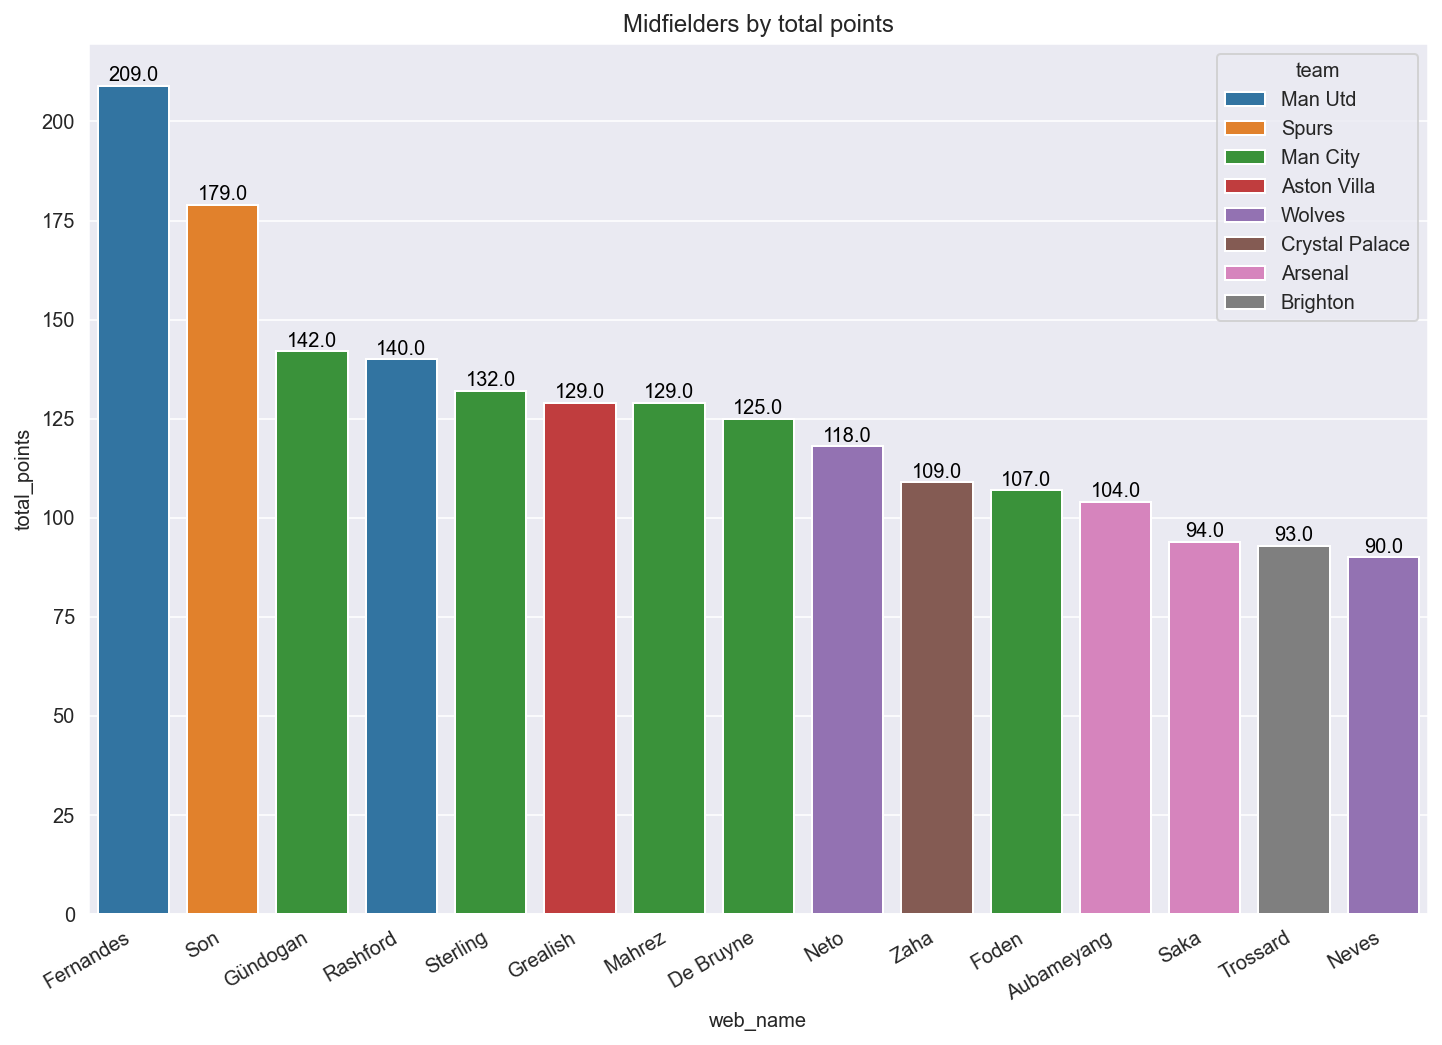

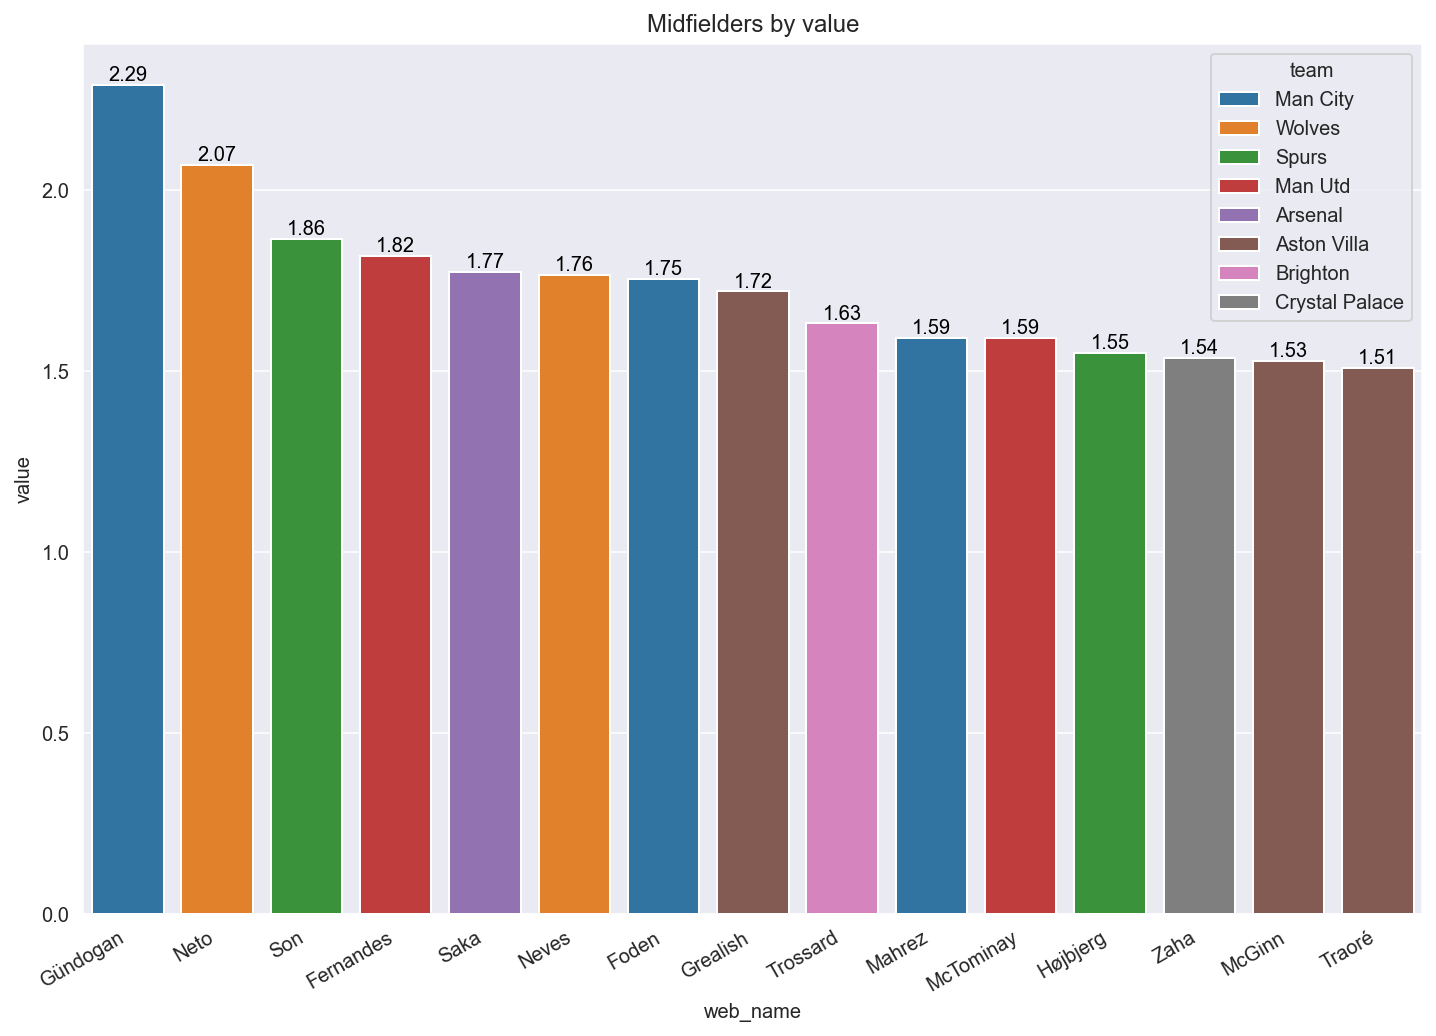

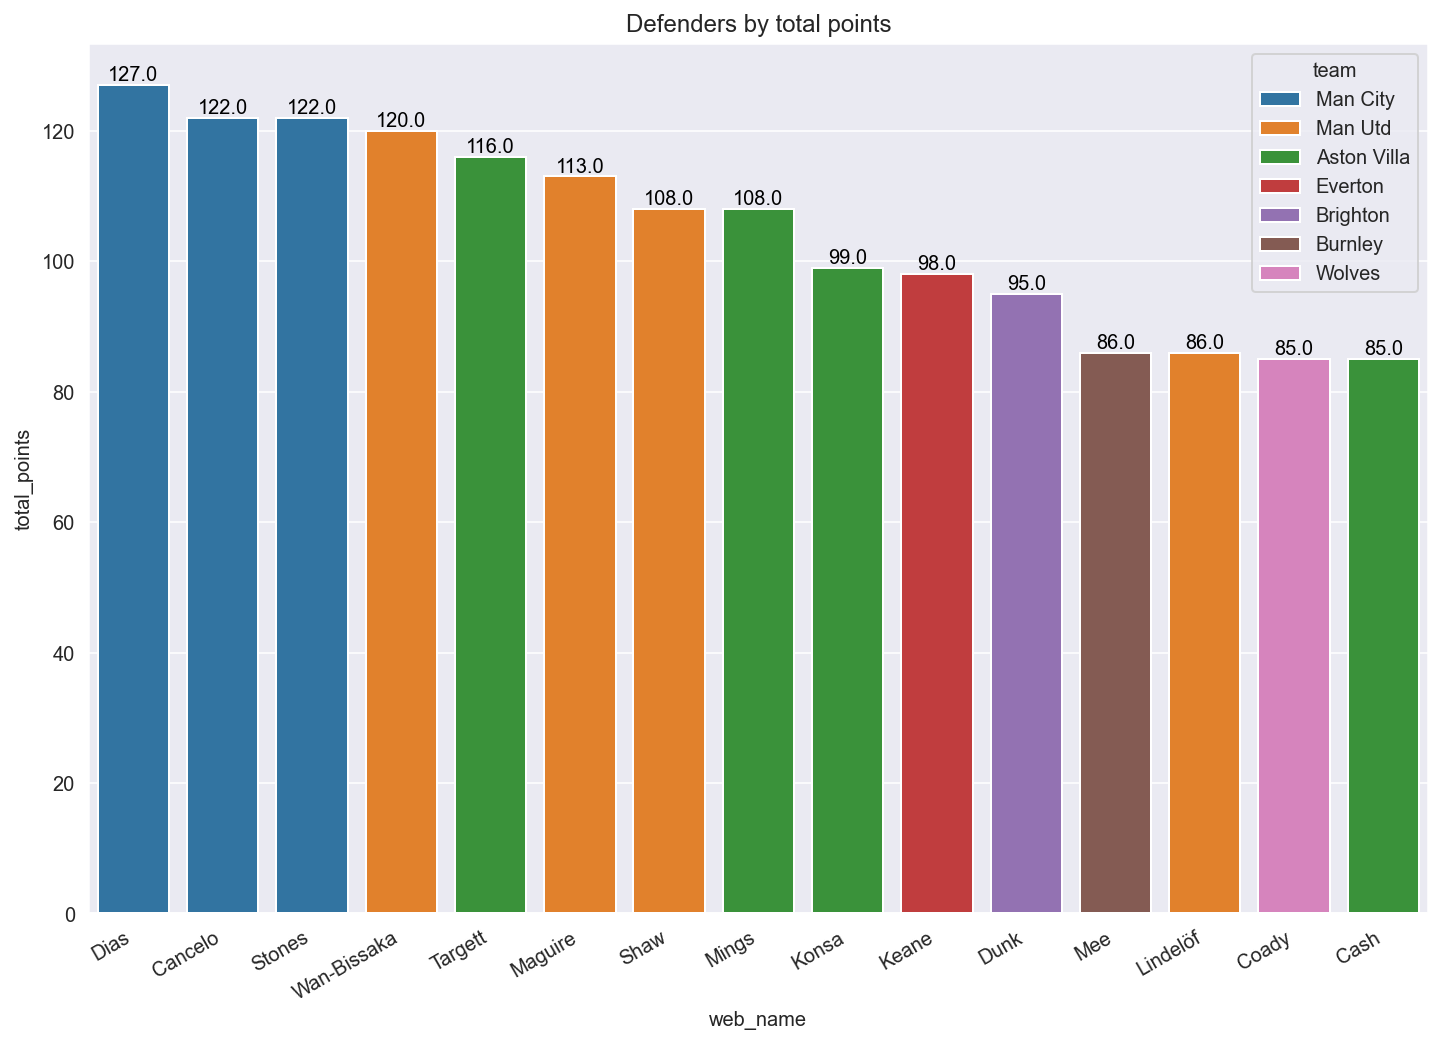

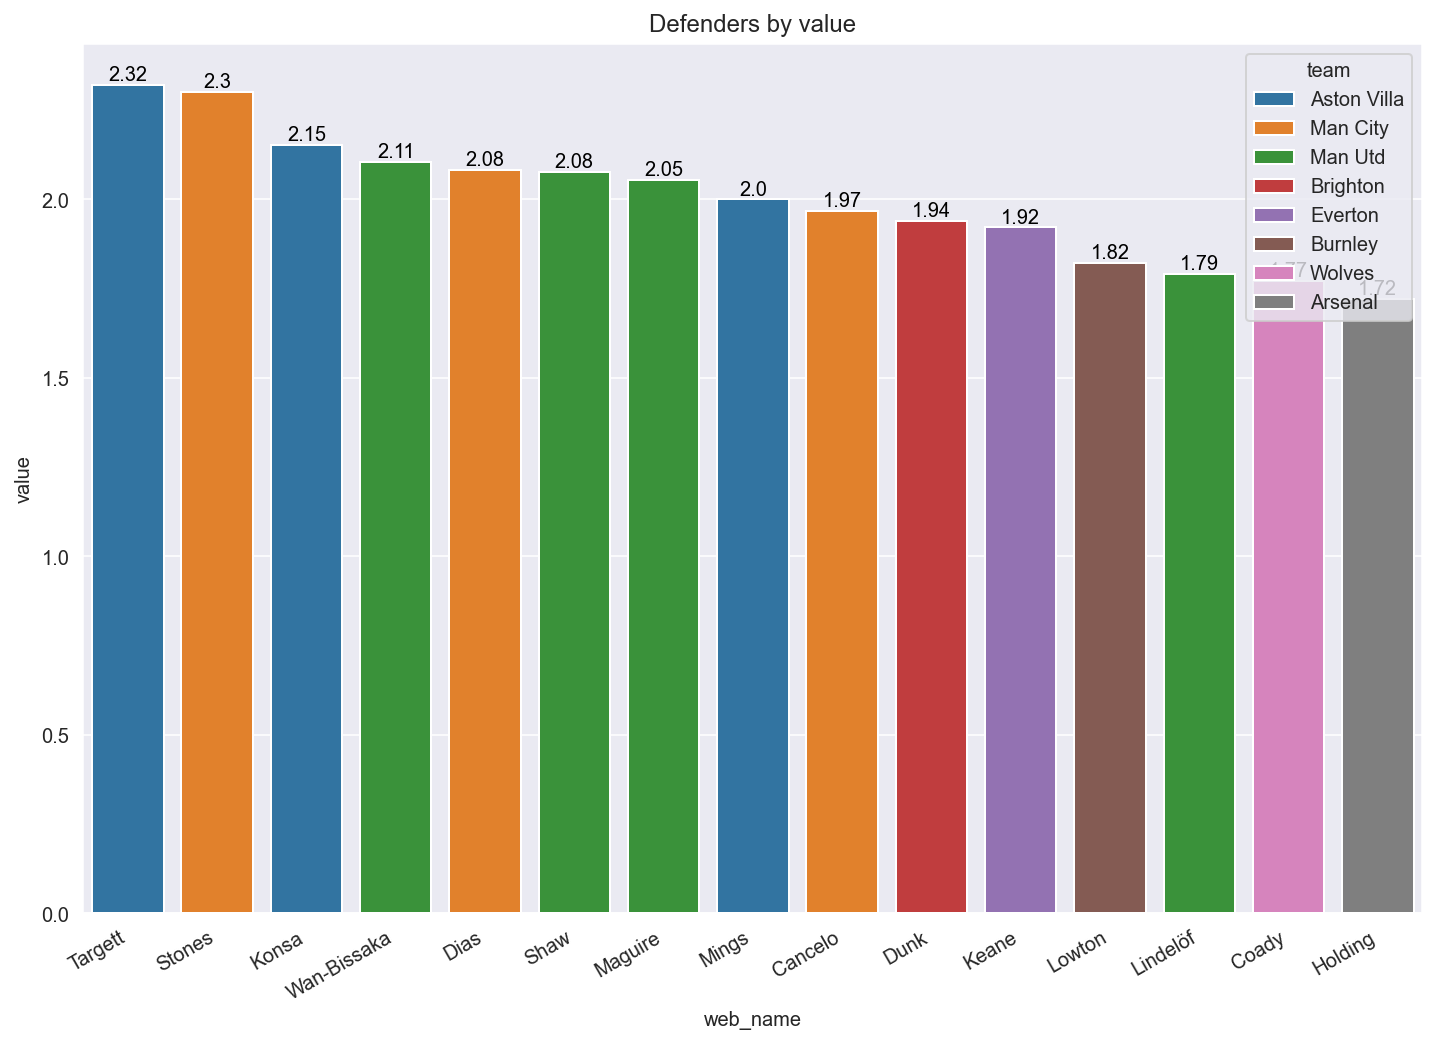

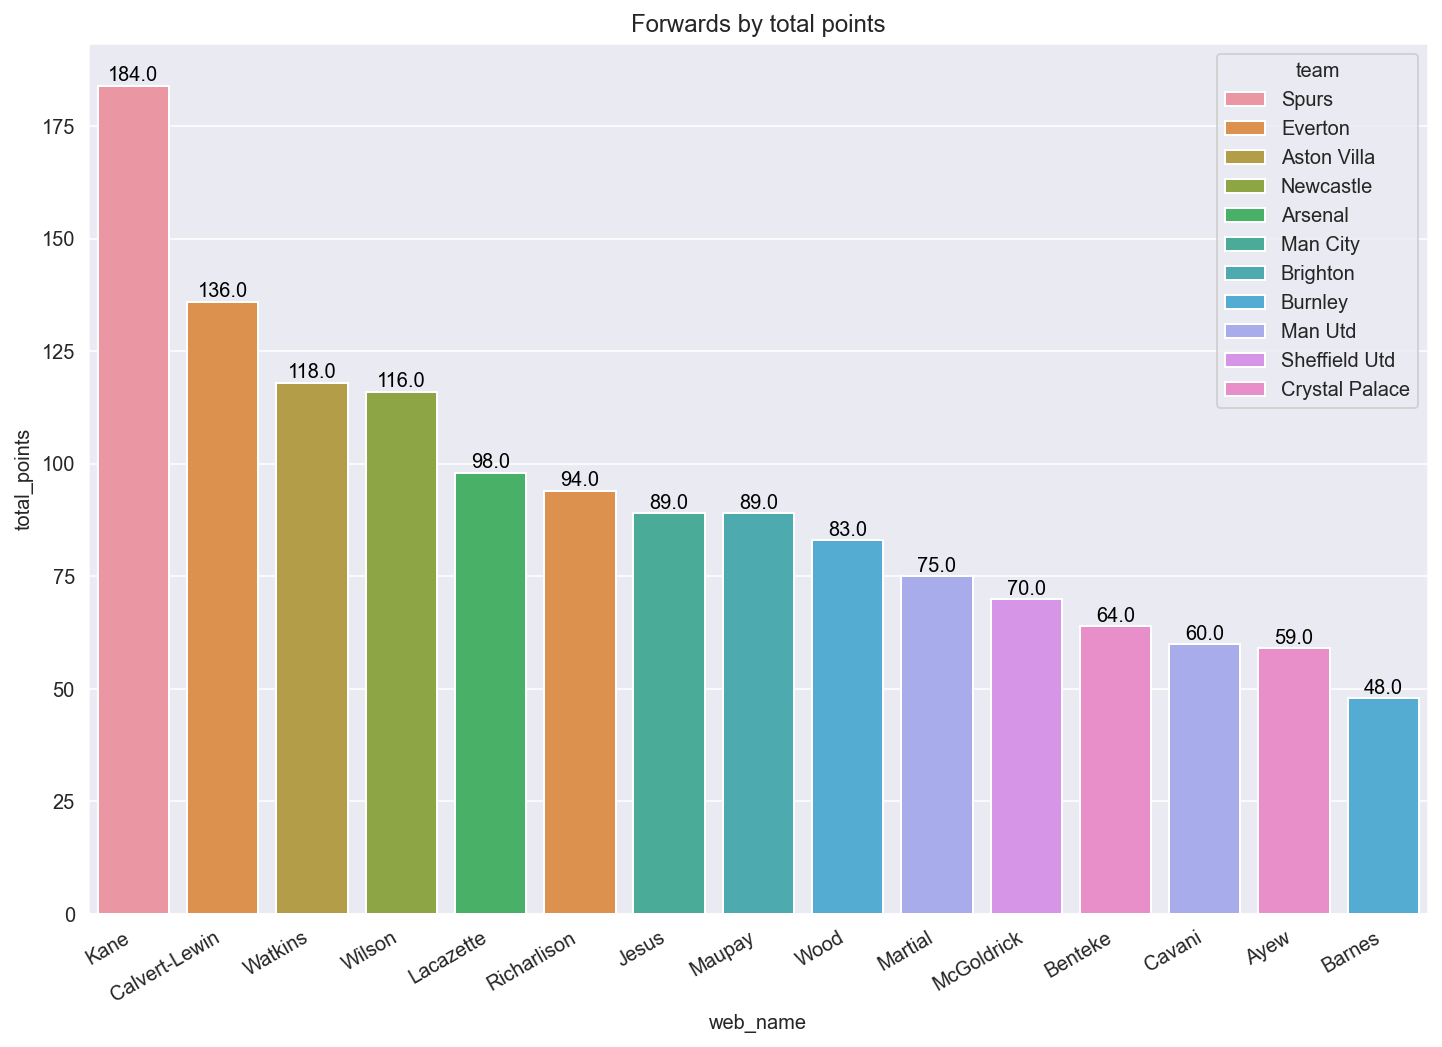

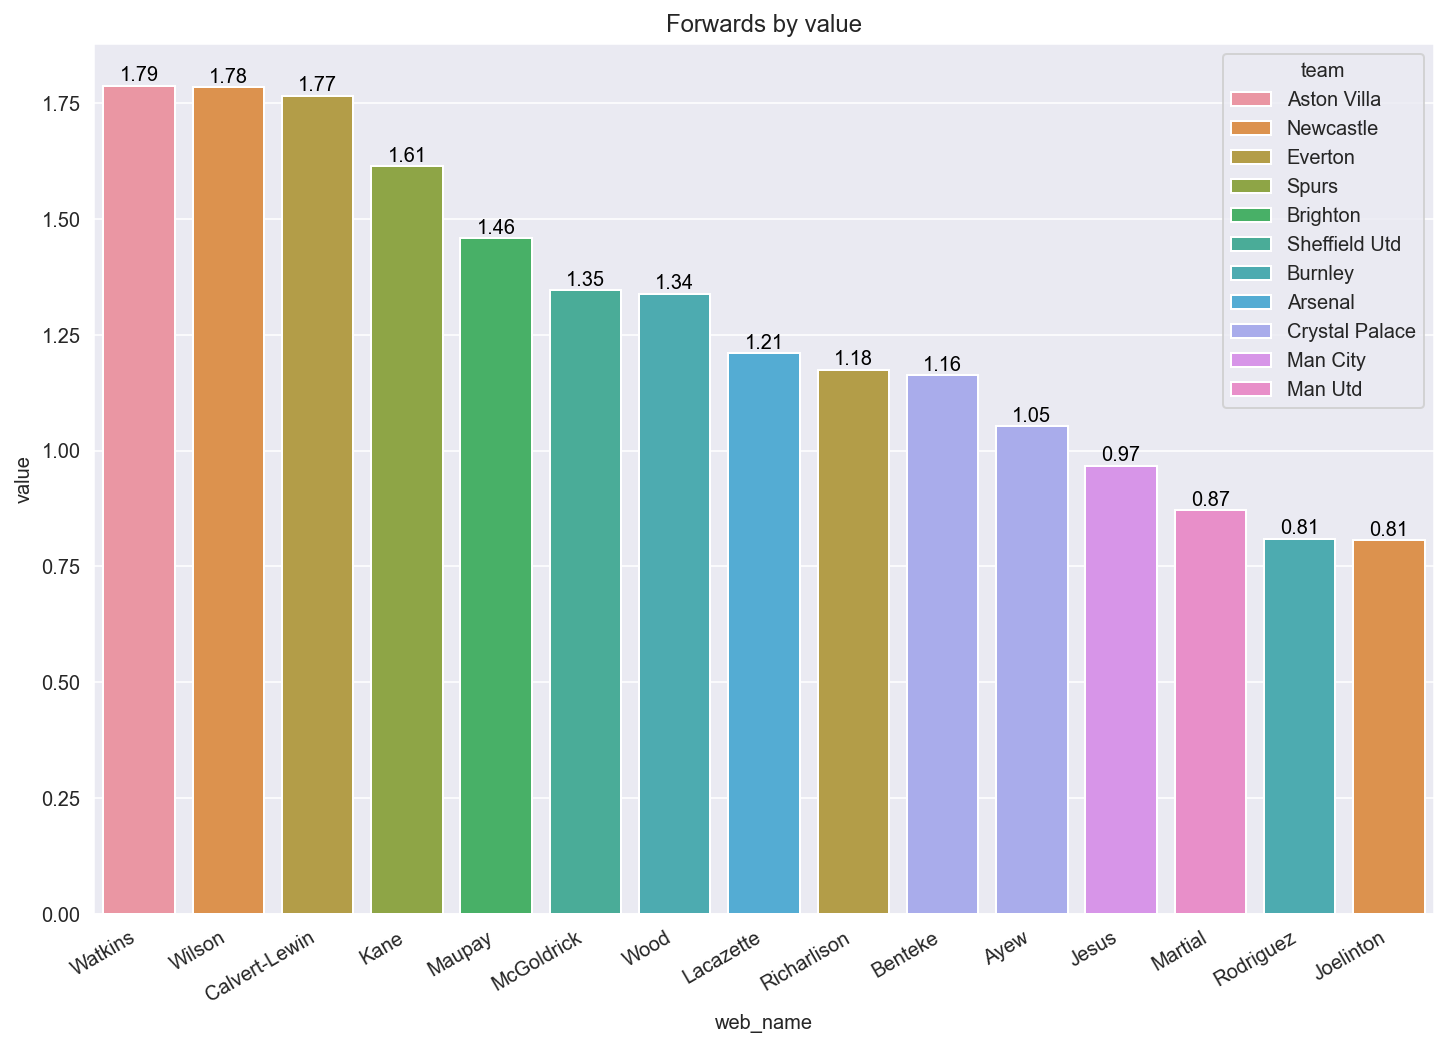

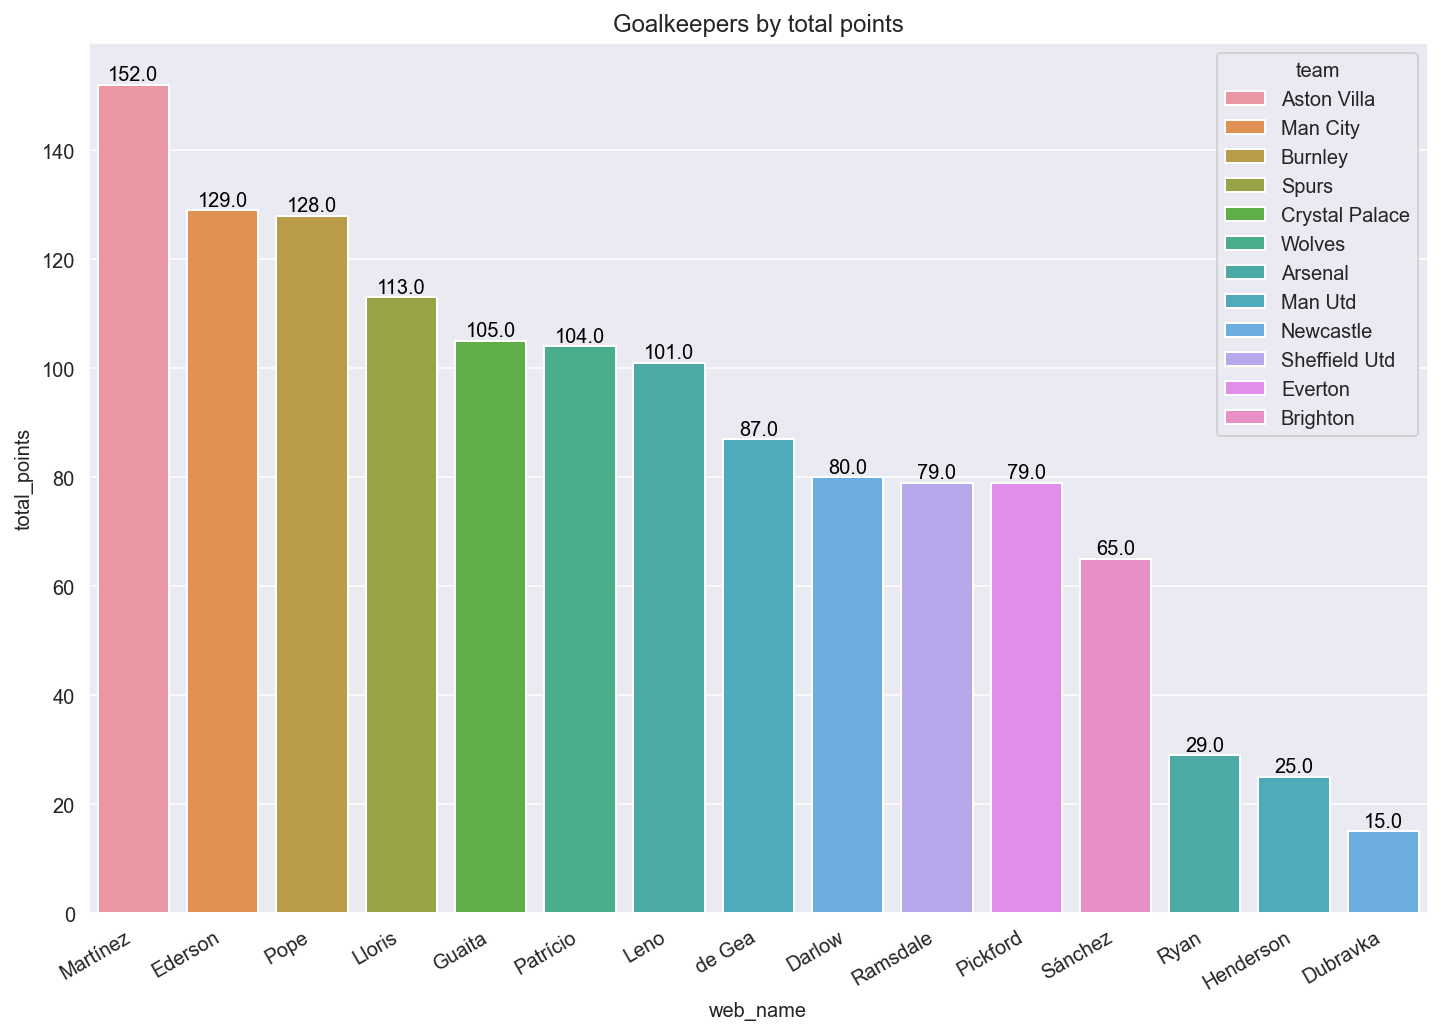

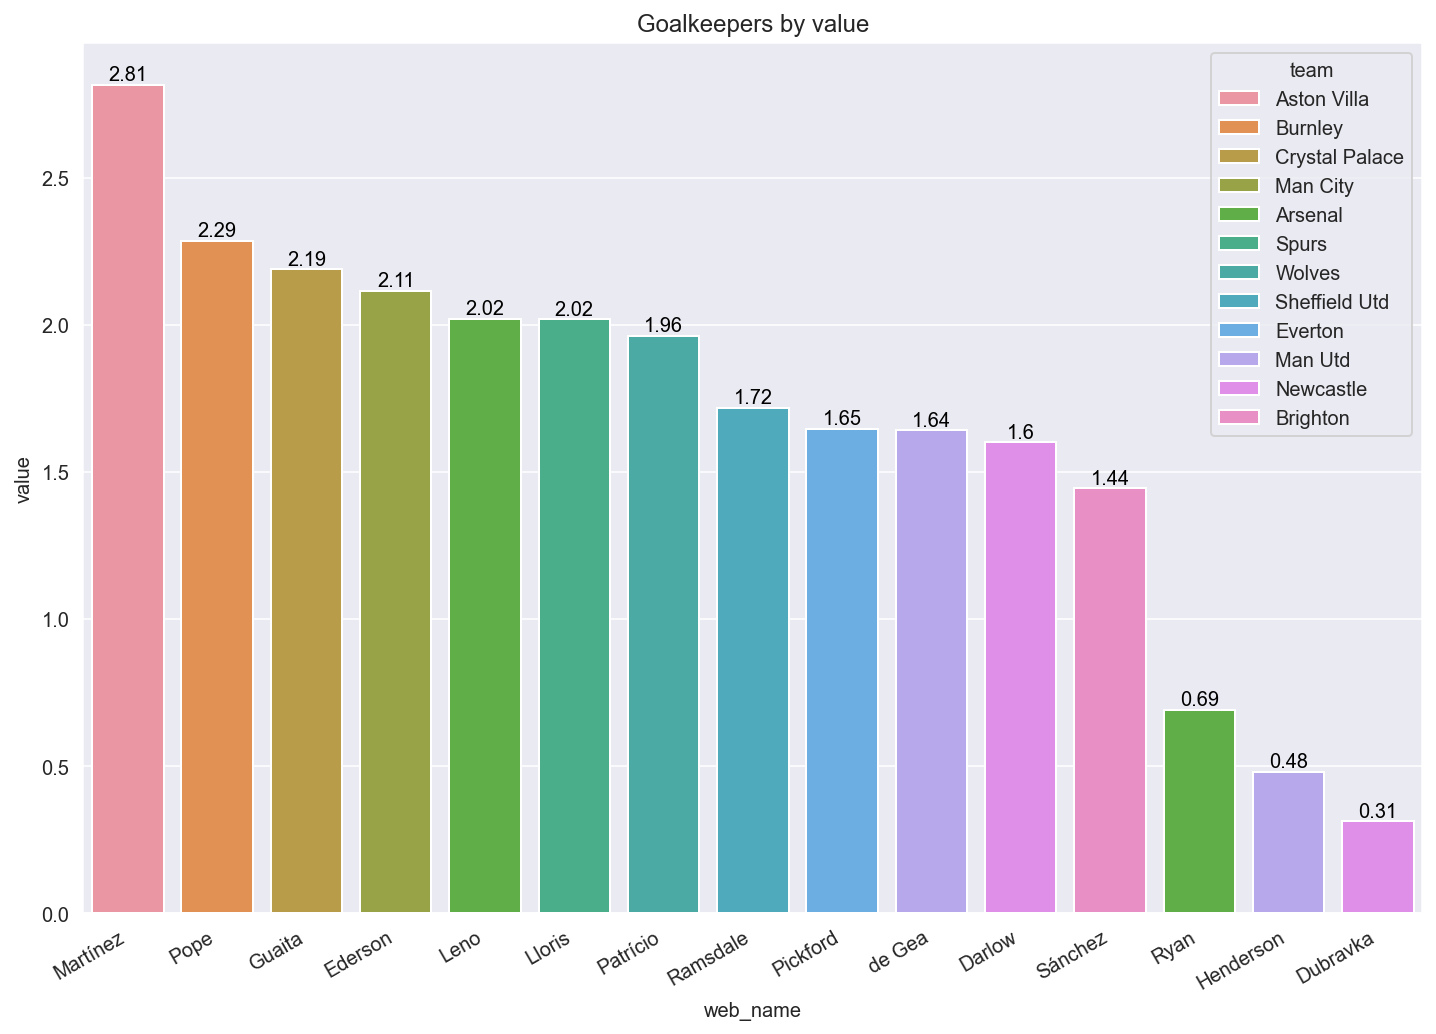

In [9]:
for pos in player_clean_df.element_type.unique():
    df_temp = player_clean_df[player_clean_df.element_type==pos]
    for column in ['total_points','value']:
        plt.figure(figsize=(12,8))
        chart=sns.barplot(x='web_name',y=column,data=df_temp.sort_values(column,ascending=False).iloc[:15],hue='team',dodge=False)
        plt.title(pos+" by "+column.replace('_',' '))
        plt.xticks(rotation=30,ha="right")
        for p in chart.patches:
            chart.annotate(round(p.get_height(),2), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
             textcoords='offset points')
        plt.show()



### Team Current Rankings

In [10]:
fixtures_df["home_win"]=(fixtures_df.team_a_score-fixtures_df.team_h_score).apply(lambda x: 1 if x < 0 else 0)
fixtures_df["draw"]=(fixtures_df.team_a_score-fixtures_df.team_h_score).apply(lambda x: 1 if x == 0 else 0)
fixtures_df["away_win"]=(fixtures_df.team_a_score-fixtures_df.team_h_score).apply(lambda x: 1 if x > 0 else 0)
fixtures_df["home_cleansheet"] = fixtures_df.team_a_score.apply(lambda x: 1 if x == 0 else 0)
fixtures_df["home_scored"] = fixtures_df.team_h_score.apply(lambda x: 1 if x != 0 else 0)
fixtures_df["away_cleansheet"] = fixtures_df.team_h_score.apply(lambda x: 1 if x == 0 else 0)
fixtures_df["away_scored"] = fixtures_df.team_a_score.apply(lambda x: 1 if x != 0 else 0)

In [11]:
away_df = fixtures_df[fixtures_df['finished']==True].groupby('team_a').agg({'finished':'count',
                                                                            'away_win':'sum',
                                                                            "team_a_score":'sum',
                                                                            "team_h_score":'sum',
                                                                            "away_cleansheet":'sum',
                                                                            "away_scored":'sum'})
home_df = fixtures_df[fixtures_df['finished']==True].groupby('team_h').agg({'finished':'count',
                                                                            'home_win':'sum',
                                                                            "team_h_score":'sum',
                                                                            "team_a_score":'sum',
                                                                            "home_cleansheet":'sum',
                                                                            "away_scored":'sum'})
away_df.columns = ["played_away","won_away",'score_away','conceded_away','cleansheet_away','scored_away']
home_df.columns = ["played_home","won_home",'score_home','conceded_home','cleansheet_home','scored_home']
results_df = pd.merge(home_df,away_df,left_index=True,right_index=True)

In [12]:
results_df['win_ratio'] = (results_df['won_home']+results_df['won_away'])/ \
                            (results_df['played_home']+results_df['played_away'])
results_df['scored_ratio'] = (results_df['scored_away']+results_df['scored_home'])/ \
                            (results_df['played_home']+results_df['played_away'])
results_df['cleansheet_ratio'] = (results_df['cleansheet_away']+results_df['cleansheet_home'])/ \
                            (results_df['played_home']+results_df['played_away'])
results_df['goals_per_match'] = (results_df['score_home']+results_df['score_away'])/ \
                            (results_df['played_home']+results_df['played_away'])
results_df['home_away_bias'] = (results_df['won_home']/results_df['played_home'])- \
                                (results_df['won_away']/results_df['played_away'])
results_df = pd.merge(teams_df[['id','name']],results_df.reset_index(),left_on='id',right_on='team_h')

### Current Team performance

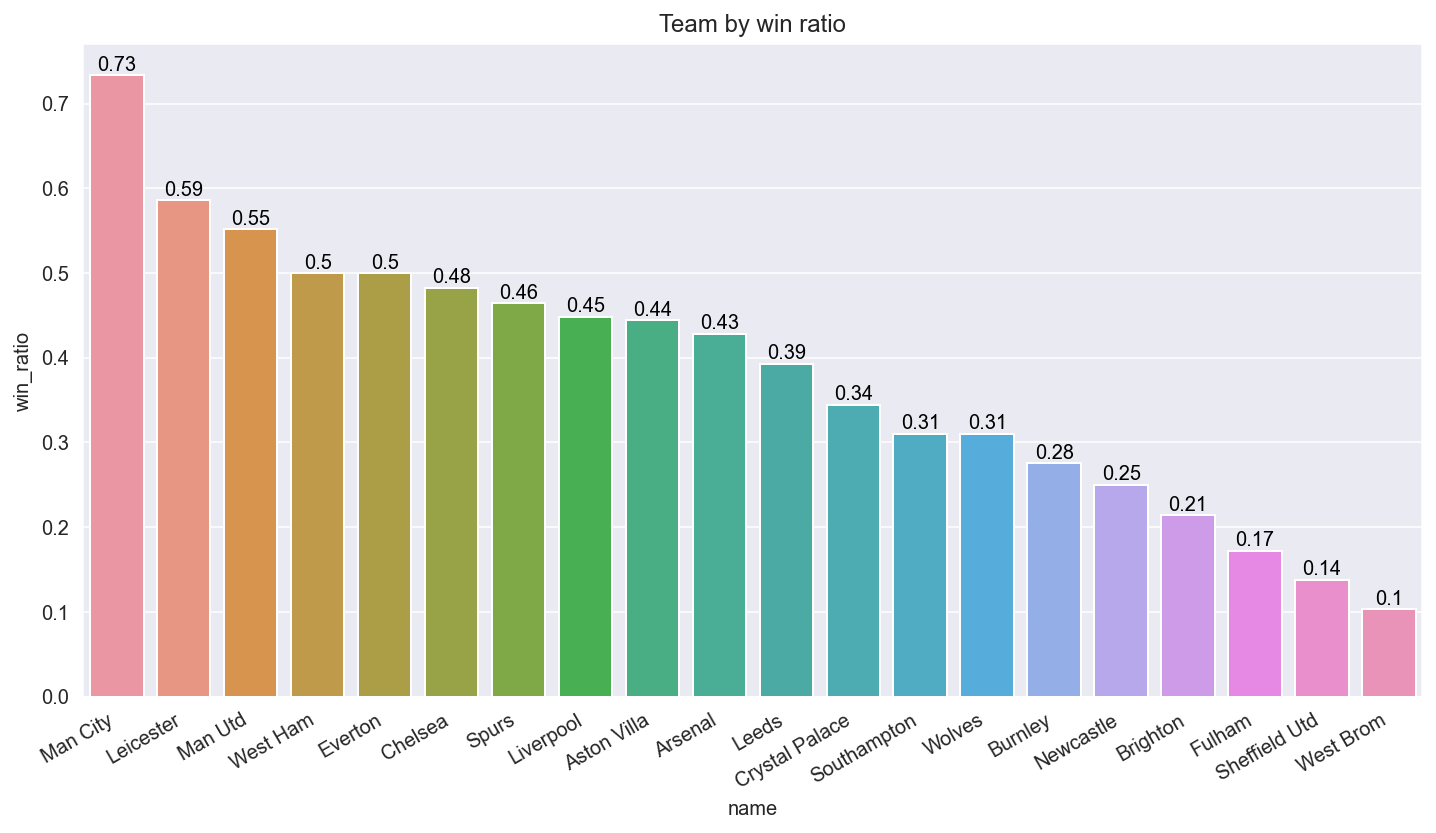

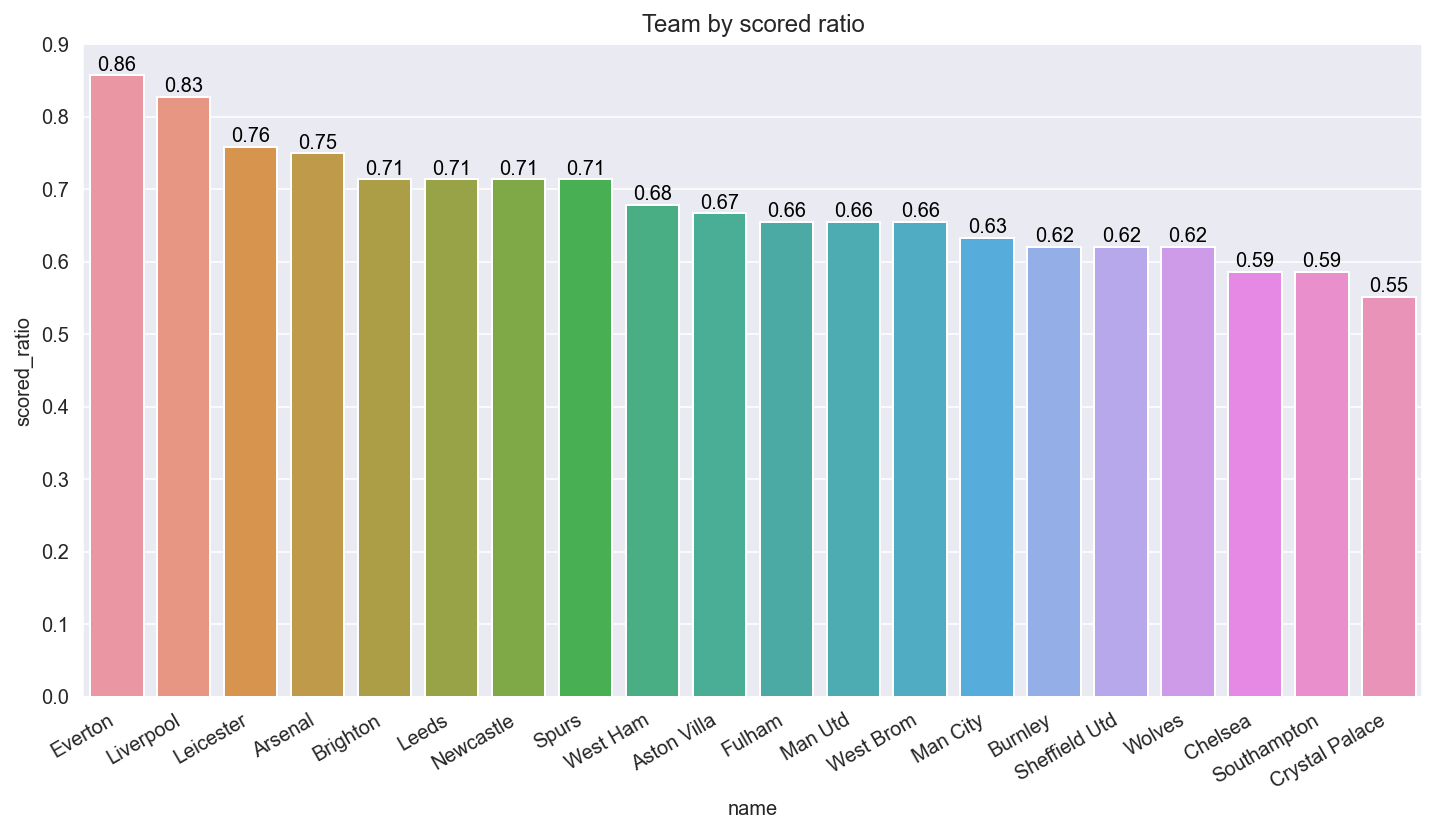

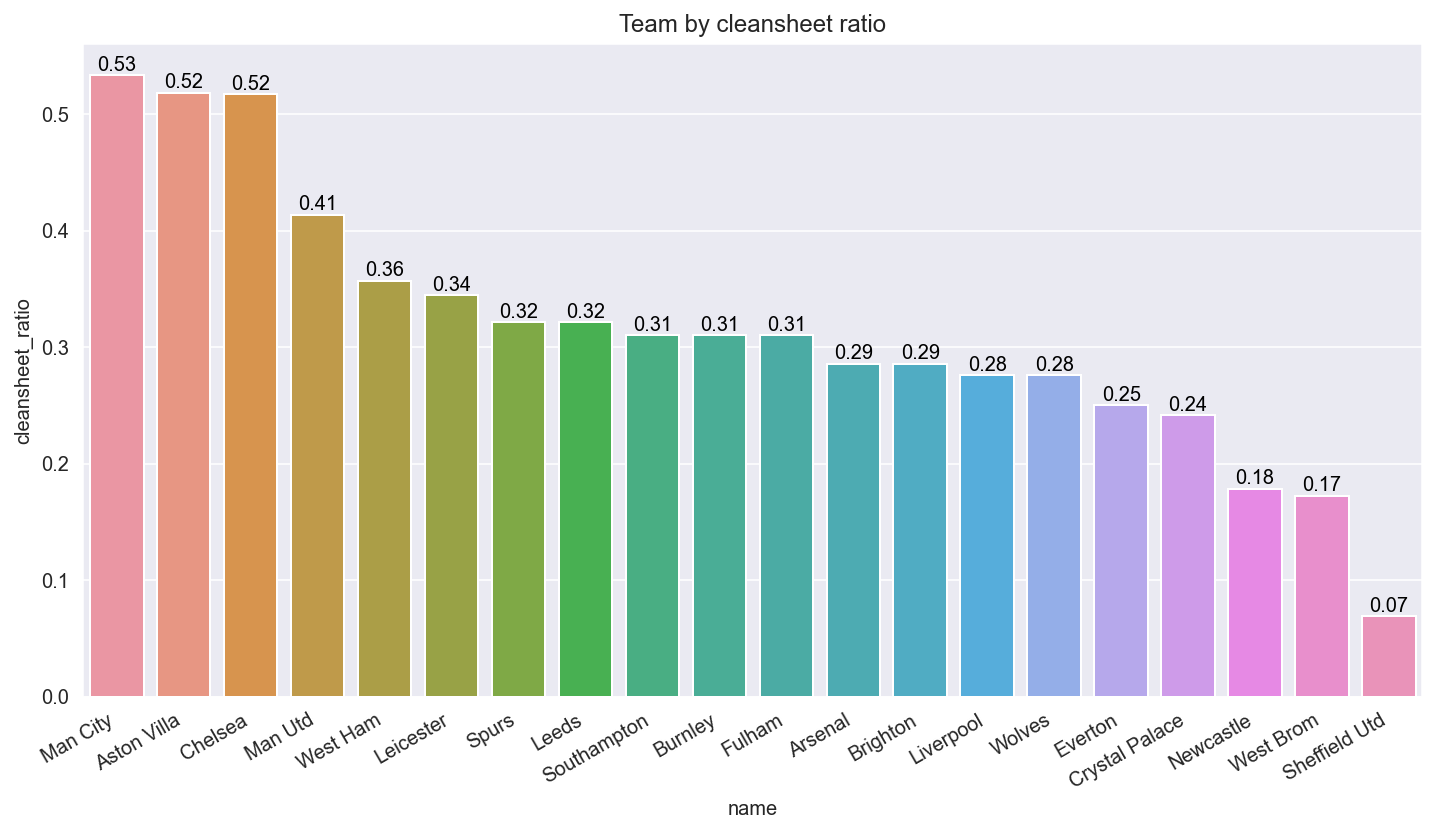

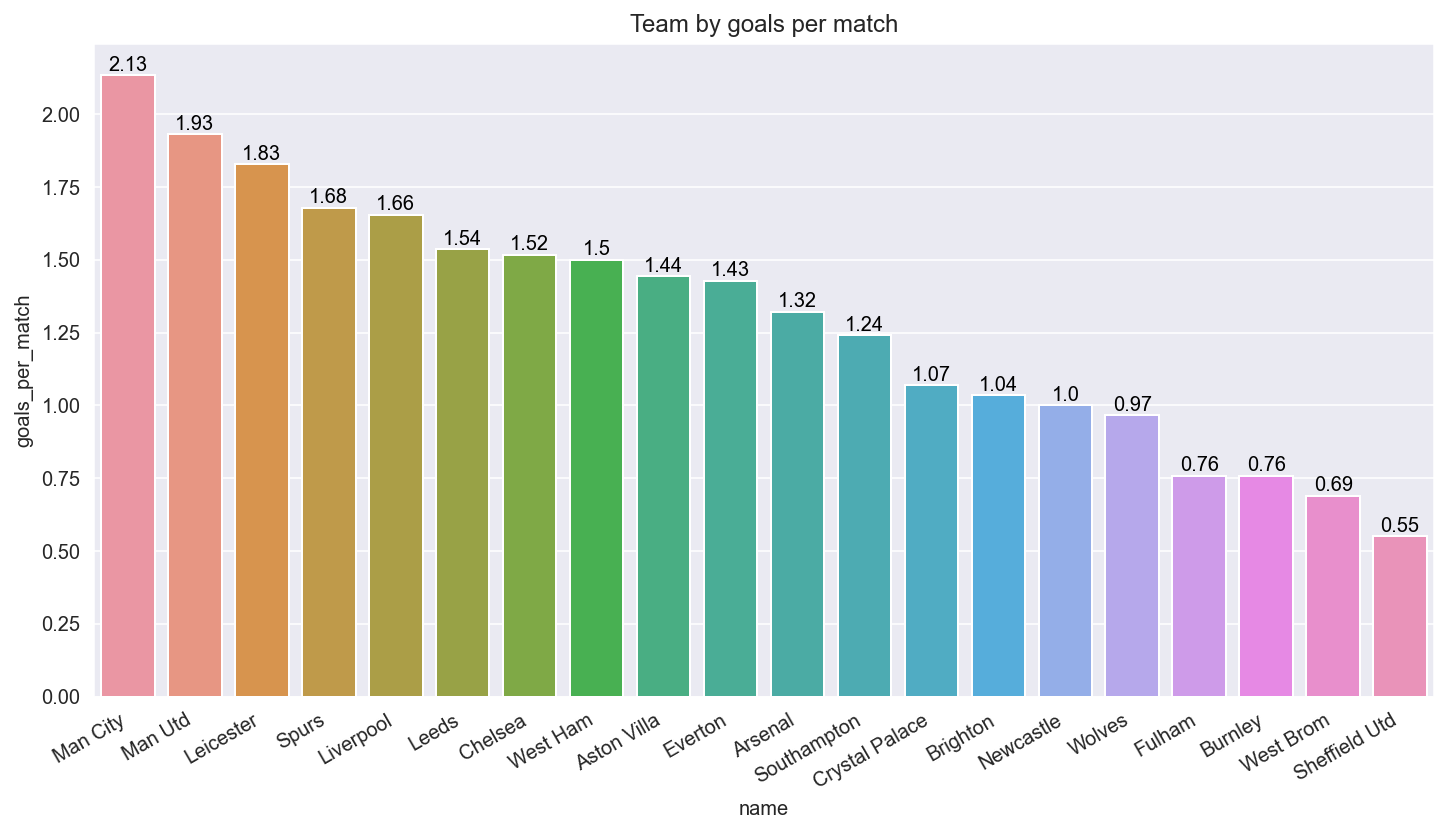

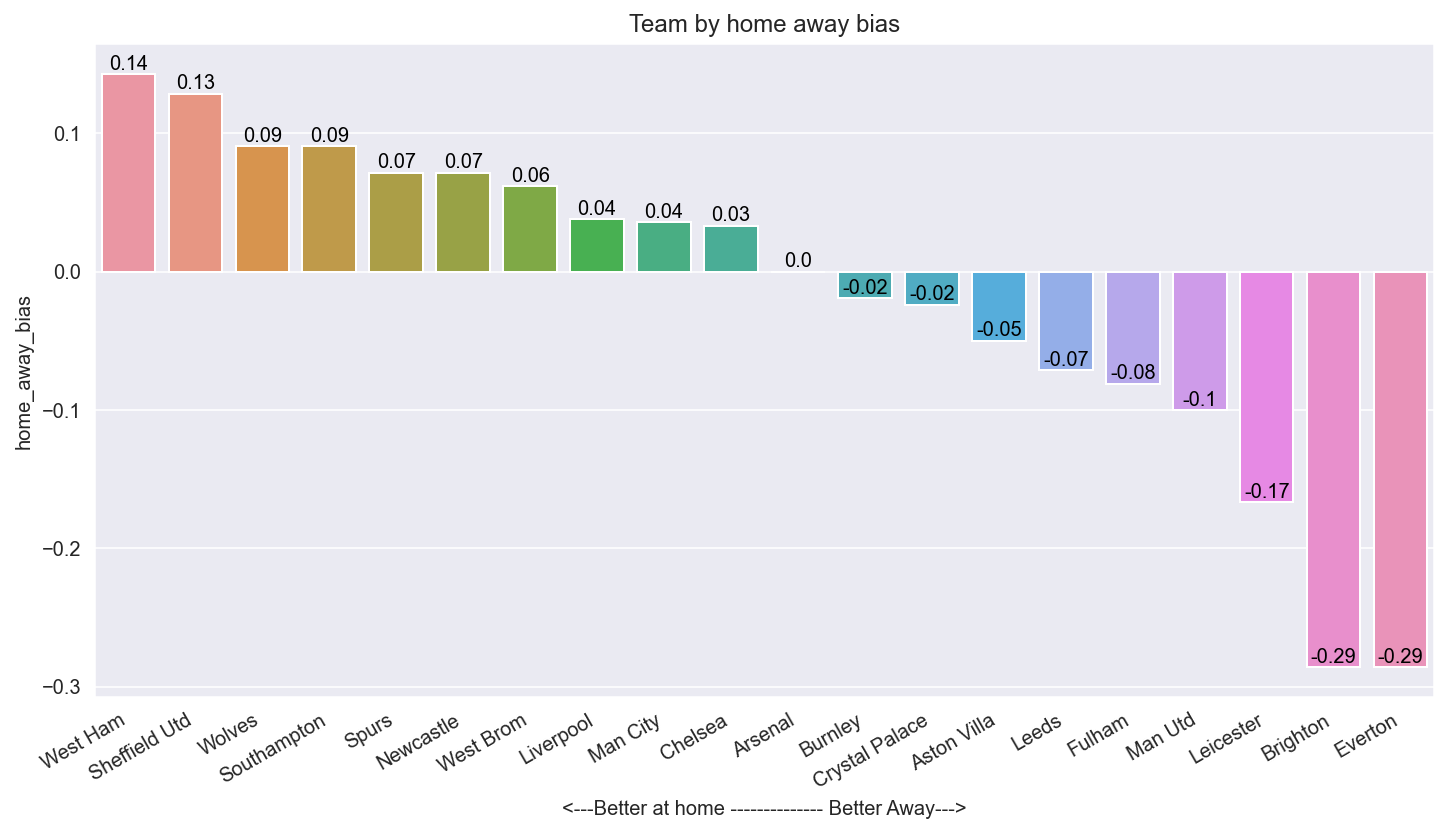

In [13]:
for column in results_df.columns[-5:]:
    plt.figure(figsize=(12,6))
    chart=sns.barplot(x='name',y=column,data=results_df.sort_values(column,ascending=False))
    plt.title("Team by "+column.replace('_',' '))
    plt.xticks(rotation=30,ha="right")
    for p in chart.patches:
        chart.annotate(round(p.get_height(),2), (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
         textcoords='offset points')
    if column == 'home_away_bias':
        plt.xlabel("<---Better at home -------------- Better Away--->")
    plt.show()


### FPL Team ranking

In [14]:
results_df.iloc[:,-5:]

,win_ratio,scored_ratio,cleansheet_ratio,goals_per_match,home_away_bias
0,0.428571,0.750000,0.285714,1.321429,0.000000
1,0.444444,0.666667,0.518519,1.444444,-0.050000
2,0.214286,0.714286,0.285714,1.035714,-0.285714
3,0.275862,0.620690,0.310345,0.758621,-0.019048
4,0.482759,0.586207,0.517241,1.517241,0.033333
5,0.344828,0.551724,0.241379,1.068966,-0.023810
6,0.500000,0.857143,0.250000,1.428571,-0.285714
7,0.172414,0.655172,0.310345,0.758621,-0.080952
8,0.586207,0.758621,0.344828,1.827586,-0.166667
9,0.392857,0.714286,0.321429,1.535714,-0.071429


### Fixture rating